# Dec 9th, 2021 (tSNR: BOLD)

**Motivation**: temporal SNR for BOLD <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [49]:
# HIDE CODE


def _load(mice, key, which: str = 'both', raw_bold: bool = False, space='individual'):
    if which == 'both':
        which = ['ca2', 'bold']
    else:
        which = [which]
    sub, ses, _ = mice.looper[key]
    
    if 'ca2' in which:
        m2d = mice.mask2d[mice.get_key(sub, ses)]
        m2d = m2d.load_ants().numpy().astype(bool)
        x2d = mice.ca_preproc[key][:]
        if x2d is None:
            out2d = None
        else:
            mu2d = x2d.mean(-1)
            sd2d = x2d.std(-1)
            snr2d = mu2d / sd2d
            out2d = {
                'm': m2d,
                'x': x2d,
                'gs': x2d[m2d].mean(0),
                'mu_abs': np.abs(x2d).mean(-1),
                'mu': mu2d,
                'sd': sd2d,
                'snr': snr2d,
                'snr_avg': bn.nanmean(snr2d[m2d]),
            }
    else:
        out2d = None

    if 'bold' in which:
        if raw_bold:
            file = 'Symmetric_N162_0.20.nii.gz'
            file = pjoin(mice.cfg.base_dir, 'Yale', 'atlases_templates', file)
            m3d = ants.image_read(file).numpy().astype(bool)
            try:
                file = next(
                    f for f in os.listdir(mice.cfg.npy_dir) if
                    all(e in f for e in [key, f"space-{space}_desc-raw"])
                )
                file = pjoin(mice.cfg.npy_dir, file)
                x3d = np.load(file)
            except StopIteration:
                x3d = None
        else:
            m3d = mice.mask3d[mice.get_key(sub, ses)]
            m3d = m3d.load_ants().numpy().astype(bool)
            x3d = mice.bold_preproc[key][:]
        if x3d is None:
            out3d = None
        else:
            mu3d = x3d.mean(-1)
            sd3d = x3d.std(-1)
            snr3d = mu3d / sd3d
            out3d = {
                'm': m3d,
                'x': x3d,
                'gs': x3d[m3d].mean(0),
                'mu_abs': np.abs(x3d).mean(-1),
                'mu': mu3d,
                'sd': sd3d,
                'snr': snr3d,
                'snr_avg': bn.nanmean(snr3d[m3d]),
            }
    else:
        out3d = None
        
    return out2d, out3d


def plot_1(gs2d, gs3d, key, nb_stds=2, ab=None, chunk_size=300, alpha=0.2):

    num = int(600 / chunk_size)
    nrows = 2 * (num + 1)

    fig, axes = create_figure(nrows, 1, (13.5, 2 * nrows),
                              gridspec_kw={'height_ratios': [1.5] * 2 + [1] * num * 2})
    axes[0].plot(gs2d, color='g')
    axes[1].plot(gs3d, color='r')
    
    sd = bn.nanstd(gs2d)
    axes[0].axhspan(- nb_stds * sd, nb_stds * sd, color='gold', lw=3, alpha=alpha)
    axes[0].axhline(- (nb_stds + 1) * sd, color='gold', ls='--')
    axes[0].axhline((nb_stds + 1) * sd, color='gold', ls='--')
    sd = bn.nanstd(gs3d)
    axes[1].axhspan(- nb_stds * sd, nb_stds * sd, color='gold', lw=3, alpha=alpha)
    axes[1].axhline(- (nb_stds + 1) * sd, color='gold', ls='--')
    axes[1].axhline((nb_stds + 1) * sd, color='gold', ls='--')
    
    if ab is not None:
        a, b = ab
        axes[0].axvspan(a * 10, b * 10, color='magenta', alpha=0.3)
        axes[1].axvspan(a, b, color='magenta', alpha=0.3)

    for i in range(1, num + 1):
        start = (i - 1) * chunk_size
        end = i * chunk_size
        intvl = range(start * 10, min(end * 10, len(gs2d)))
        axes[2 * i].plot(intvl, gs2d[intvl], color='dimgrey')

        intvl = range(start, min(end, len(gs3d)))
        axes[2 * i + 1].plot(intvl, gs3d[intvl], color='k')
        
        sd = bn.nanstd(gs2d[intvl])
        axes[2 * i].axhspan(- nb_stds * sd, nb_stds * sd, color='gold', alpha=alpha)
        sd = bn.nanstd(gs3d[intvl])
        axes[2 * i + 1].axhspan(- nb_stds * sd, nb_stds * sd, color='gold', alpha=alpha)
        

    for i in range(2):
        axes[2 * i].axvspan(0, 50 * 10, color='dimgrey', alpha=0.3)
        axes[2 * i + 1].axvspan(0, 50, color='dimgrey', alpha=0.3)

    fig.suptitle(f"plot #1, {key}", fontsize=14, y=1.02)
    plt.show()
    
    return fig, axes


def plot_2(out2d, key, threshold=0.05):
    xlist = [out2d['mu_abs'], out2d['mu'], out2d['sd'], out2d['snr'], out2d['m']]
    mu_abs, mu, sd, snr, m = filter_boundaries(xlist, out2d['m'])
    snr = np.abs(snr)
    
    fig1, axes = create_figure(1, 4, (13, 3.2), gridspec_kw={'width_ratios': [1, 1, 1, 1.5]})

    im = axes[0].imshow(mu_abs, cmap='Spectral')
    plt.colorbar(im, ax = axes[0], shrink=0.7)

    im = axes[1].imshow(mu, cmap='Spectral')
    plt.colorbar(im, ax = axes[1], shrink=0.7)

    im = axes[2].imshow(sd, cmap='Spectral')
    plt.colorbar(im, ax = axes[2], shrink=0.7)

    im = axes[3].imshow(snr, cmap='Spectral')
    plt.colorbar(im, ax = axes[3])

    axes[0].set_title(r'$\mu$ (abs)')
    axes[1].set_title(r'$\mu$')
    axes[2].set_title(r'$\sigma$')
    axes[3].set_title(r'tSNR $ = abs(\mu / \sigma)$')
    fig1.suptitle(f"plot #2, {key}", fontsize=14, y=1.02)
    remove_ticks(axes)
    plt.show()
    
    fig2, axes = create_figure(1, 2, (12, 2.7))

    vals = snr[np.logical_and(m, np.isfinite(snr))]
    vals = np.abs(vals)
    q = np.quantile(vals, threshold)
    sns.histplot(vals, ax=axes[0])
    axes[0].axvline(q, color='r', ls='--')
    axes[1].imshow(snr > q)
    remove_ticks(axes[1])
    plt.show()
    
    gs_good = out2d['x'][np.logical_and(out2d['m'], np.abs(out2d['snr']) > q)].mean(0)
    gs_bad = out2d['x'][np.logical_and(out2d['m'], np.abs(out2d['snr']) <= q)].mean(0)
    
    fig3, ax = create_figure(1, 1, (13, 4), sharex='all', sharey='all')
    ax.plot(gs_bad, color='r', lw=0.7, label='gs bad')
    ax.plot(gs_good, color='k', lw=0.9, label='gs good')
    ax.legend(fontsize='large')
    ax.grid()
    plt.show()
    
    return fig1, fig2, fig3


def plot_3(out3d, key, display: bool = True, threshold=0.05, slice_ids=None):
    slice_ids = slice_ids if slice_ids else [10, 20, 30, 40]
    snr = np.abs(out3d['snr'])
    
    fig1, axes = create_figure(
        3, len(slice_ids) + 1, figsize=(13, 6.),
        gridspec_kw={'width_ratios': [1] * len(slice_ids) + [1.6]})

    for i in range(3):
        for j, s in enumerate(slice_ids):
            x2plt = np.take(snr, s, axis=i)
            if i == 2:
                x2plt = x2plt.T
            im = axes[i, j].imshow(x2plt, cmap='Spectral')
            plt.colorbar(im, ax=axes[i, j], shrink=0.7)
        x2plt = bn.nanmean(snr, axis=i)
        x2plt = filter_boundaries(x2plt, out3d['m'].mean(i).astype(bool))
        if i == 2:
            x2plt = x2plt.T
        im = axes[i, -1].imshow(x2plt, cmap='Spectral')
        plt.colorbar(im, ax=axes[i, -1], shrink=0.7)
        fig1.suptitle(f"plot #3, {key}", fontsize=14, y=1.01)

    remove_ticks(axes)
    plt.show()

    fig2, axes = create_figure(1, 4, (13, 2.7))

    vals = out3d['snr'][np.logical_and(out3d['m'], np.isfinite(out3d['snr']))]
    vals = np.abs(vals)
    q = np.quantile(vals, threshold)
    above = out3d['snr'] > q
    sns.histplot(vals, ax=axes[0])
    axes[0].axvline(q, color='r', ls='--')
    for i in range(1, 4):
        x2plt = above.mean(i - 1)
        if i == 3:
            x2plt = x2plt.T
        axes[i].imshow(x2plt)
        remove_ticks(axes[i])
    plt.show()

    return fig1, fig2


def plot_4(mice, sub, ses, brief: bool = True, display: bool = True, threshold=0.05):
    data = []
    for run in mice.cfg.run_ids:
        key = mice.get_key(sub, ses, run)
        out2d, _ = _load(mice, key, 'ca2')

        snr, m = filter_boundaries([out2d['snr'], out2d['m']], out2d['m'])
        vals = snr[np.logical_and(m, np.isfinite(snr))]
        vals, snr = np.abs(vals), np.abs(snr)
        q = np.quantile(vals, threshold)

        data.append((snr, m, vals, q))

    if brief:
        nrows = 2
        fig, axes = create_figure(
            nrows=nrows,
            ncols=len(data),
            figsize=(13, 2 * nrows),
        )
        for i in range(len(data)):
            snr, _, _, q = data[i]
            axes[0, i].imshow(snr, cmap='Spectral')
            axes[1, i].imshow(snr > q)
            axes[0, i].set_title(f"run # {i+1}", y=1.03)
        remove_ticks(axes)
        sup = f"{mice.get_key(sub, ses)} / temporal SNR = "
        sup += r'$\mu / \sigma$'
        sup = fig.suptitle(sup, fontsize=14, y=1.03)
    
    else:
        ncols = 6
        nrows = int(np.ceil(len(data) / 2))
        fig, axes = create_figure(
            nrows=nrows,
            ncols=ncols,
            figsize=(13, 2. * nrows),
            gridspec_kw={'width_ratios': [1.4, 1, 1.2] * 2},
        )
        for i in range(nrows):
            for j in range(2):
                idx = 2 * i + j
                try:
                    snr, m, vals, q = data[idx]
                except IndexError:
                    continue

                im = axes[i, 3 * j].imshow(snr, cmap='Spectral')
                plt.colorbar(im, ax=axes[i, 3 * j], shrink=0.8)
                axes[i, 3 * j + 1].imshow(snr > q)
                sns.histplot(vals, ax=axes[i, 3 * j + 2])
                axes[i, 3 * j + 2].axvline(q, color='r', ls='--', lw=1, label=f"q = {q:0.3f}")
                axes[i, 3 * j + 2].legend()
                axes[i, 3 * j + 2].grid()
                remove_ticks(axes[i, :2])
                remove_ticks(axes[i, 3:5])
        remove_ticks(axes.flat[-1])
        sup = f"{mice.get_key(sub, ses)} / temporal SNR = "
        sup += r'$\mu / \sigma$'
        sup = fig.suptitle(sup, fontsize=17, y=1.03)
        
    if display:
        plt.show()
    else:
        plt.close()
        
    return fig, sup, axes


def plot_5(
    mice: Mice,
    sub: int,
    ses: int,
    threshold=0.5,
    space: str = 'N162',
    display: bool = True,
    raw_bold: bool = True,):
    
    data = {}
    for run in mice.cfg.run_ids:
        key = mice.get_key(sub, ses, run)
        _, out3d = _load(mice, key, 'bold', raw_bold=raw_bold, space=space)
        if out3d is None:
            continue

        snr, m = out3d['snr'], out3d['m']
        vals = snr[np.logical_and(m, np.isfinite(snr))]
        vals, snr = np.abs(vals), np.abs(snr)
        q = np.quantile(vals, threshold)

        data[run] = (snr, m, vals, q)

    nrows = len(data)
    fig, axes = create_figure(nrows, 4, (13, 2.2 * nrows), gridspec_kw={'width_ratios': [1.8, 1, 1, 1]})
    for i in range(nrows):
        snr, m, vals, q = data[i + 1]
        sns.histplot(vals, ax=axes[i, 0])
        axes[i, 0].axvline(q, color='r', ls='--', lw=0.9, label=f"q = {q:0.3f}")
        axes[i, 0].set_ylabel(f"run # {i + 1}\n", fontsize=13)
        axes[i, 0].legend()
        
        above = snr > q
        for j in range(1, 4):
            x2plt = above.mean(j - 1)
            if j == 3:
                x2plt = x2plt.T
            axes[i, j].imshow(x2plt)
            remove_ticks(axes[i, j])
    sup = f"{mice.get_key(sub, ses)} (bold) / temporal SNR = "
    sup += r'$\mu / \sigma$'
    sup = fig.suptitle(sup, fontsize=17, y=1.03)
    
    if display:
        plt.show()
    else:
        plt.close()
    
    return data, (fig, sup, axes)

In [3]:
mice = Mice((768, 4))
mice.setup_func_data('rest', bold_gsr=False)
mice.setup_preproc_data(bold_gsr=False)
mice.setup_anat_data()

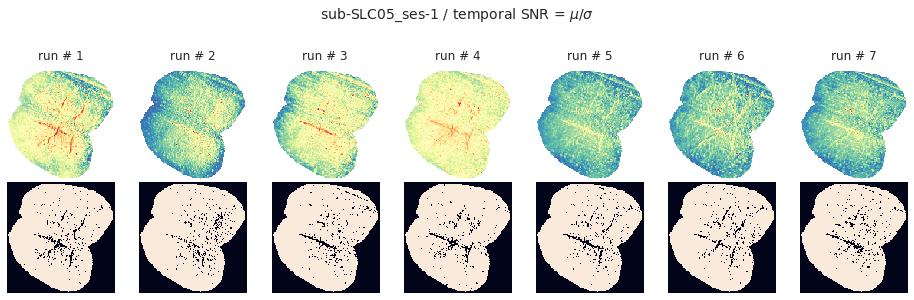

CPU times: user 42.6 s, sys: 2min 2s, total: 2min 45s
Wall time: 3min 47s


In [4]:
%%time
fig, sup, axes = plot_4(mice, 5, 1, brief=True, display=True)

In [5]:
key = 'sub-SLC05_ses-1_run-3'
_, out3d = _load(mice, key, 'bold', True)

[<matplotlib.lines.Line2D object at 0x7ec2ac58ad00>]

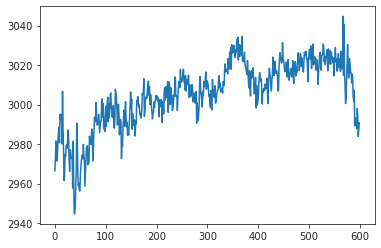

In [6]:
plt.plot(out3d['gs'])

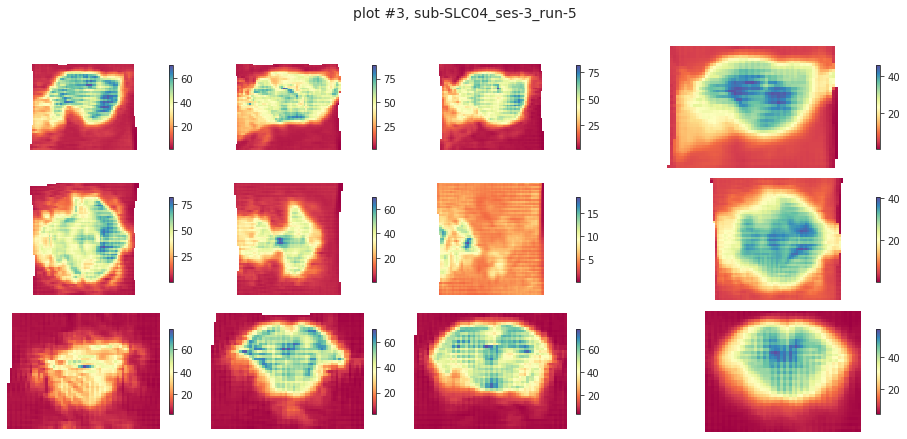

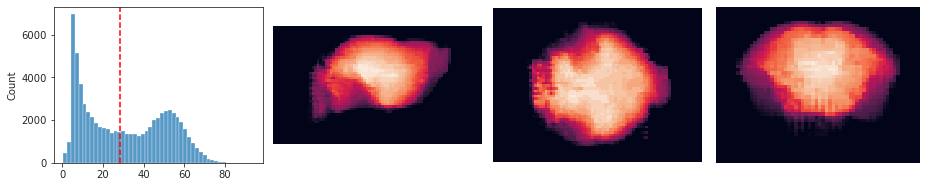

In [42]:
key = 'sub-SLC04_ses-3_run-5'
_, out3d = _load(mice, key, 'bold', raw_bold=True, space='N162')
_ = plot_3(out3d, key, threshold=0.50, slice_ids=[20, 30, 40])

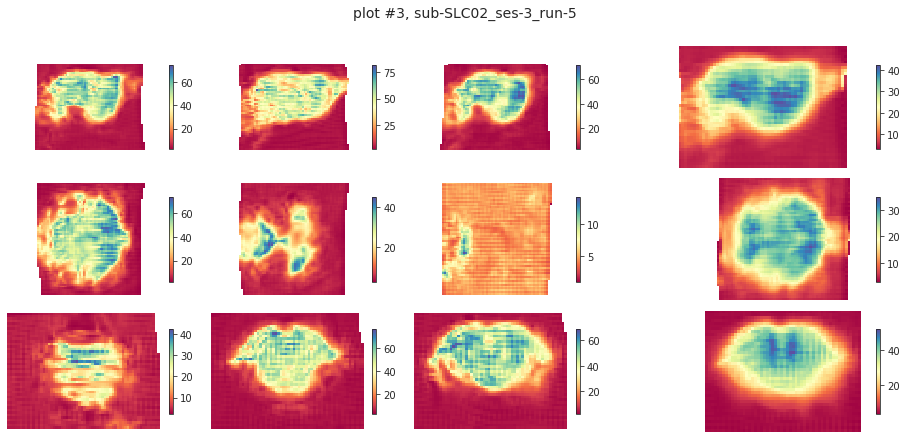

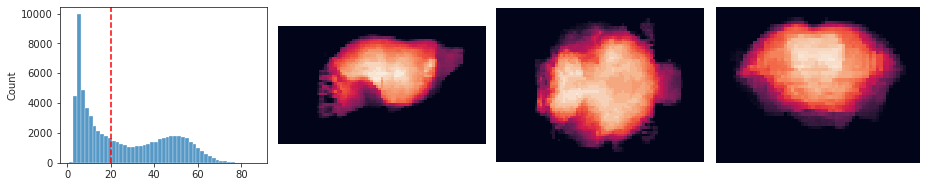

In [43]:
key = 'sub-SLC02_ses-3_run-5'
_, out3d = _load(mice, key, 'bold', raw_bold=True, space='N162')
_ = plot_3(out3d, key, threshold=0.50, slice_ids=[20, 30, 40])

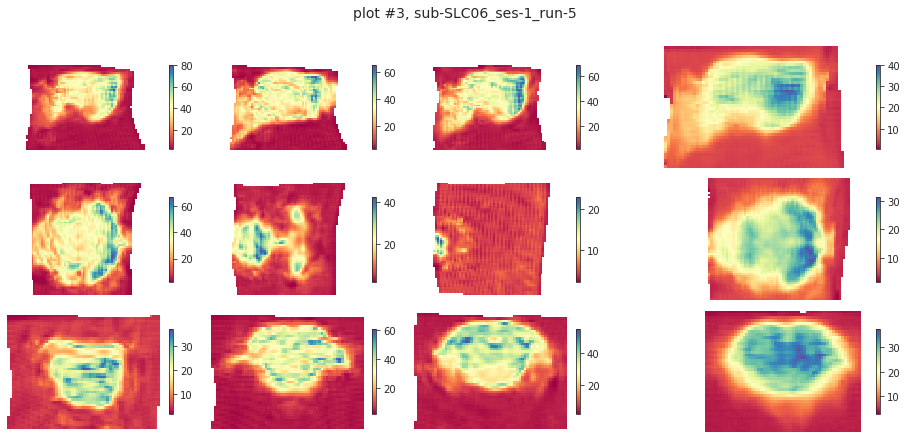

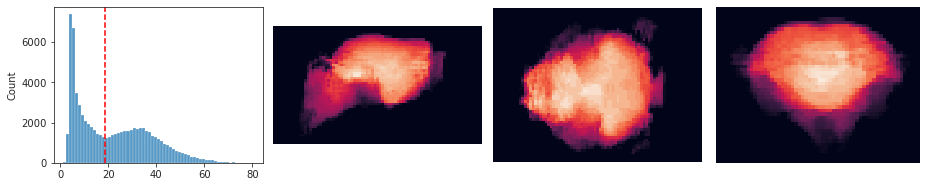

In [44]:
key = 'sub-SLC06_ses-1_run-5'
_, out3d = _load(mice, key, 'bold', raw_bold=True, space='N162')
_ = plot_3(out3d, key, threshold=0.50, slice_ids=[20, 30, 40])

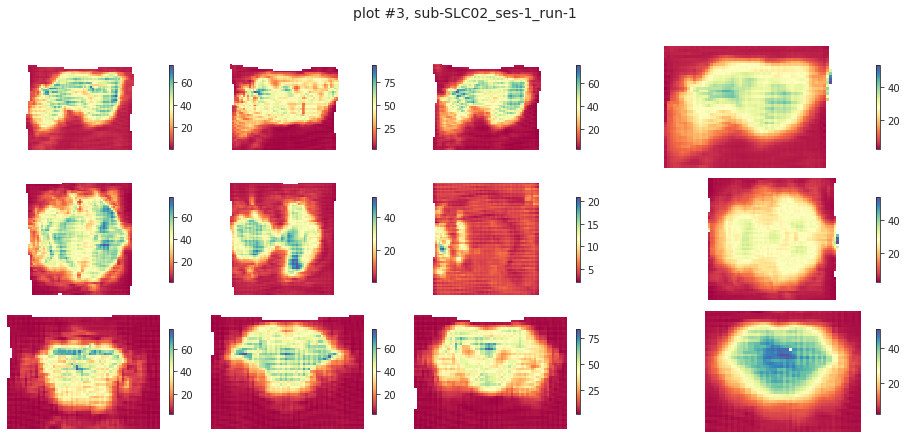

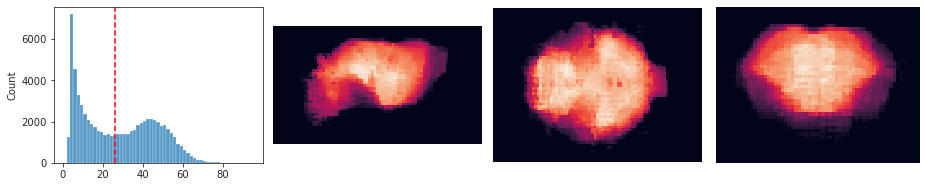

In [45]:
key = 'sub-SLC02_ses-1_run-1'
_, out3d = _load(mice, key, 'bold', raw_bold=True, space='N162')
_ = plot_3(out3d, key, threshold=0.50, slice_ids=[20, 30, 40])

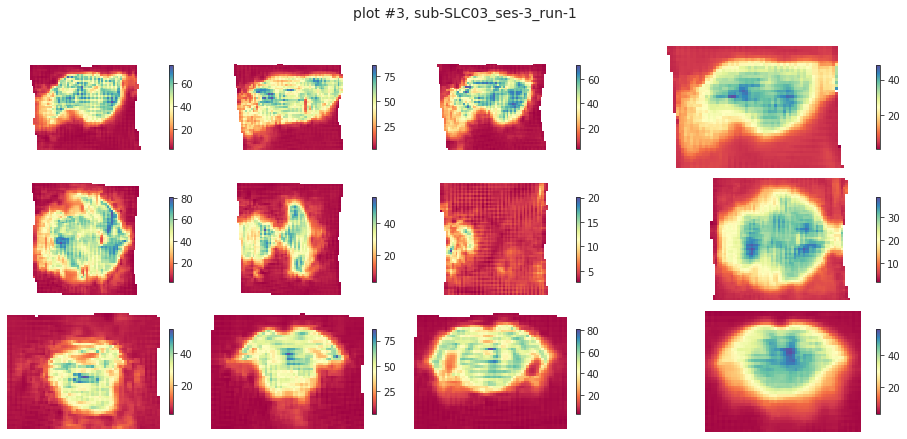

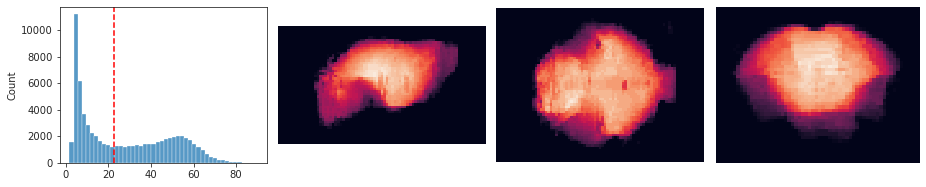

In [46]:
key = 'sub-SLC03_ses-3_run-1'
_, out3d = _load(mice, key, 'bold', raw_bold=True, space='N162')
_ = plot_3(out3d, key, threshold=0.50, slice_ids=[20, 30, 40])

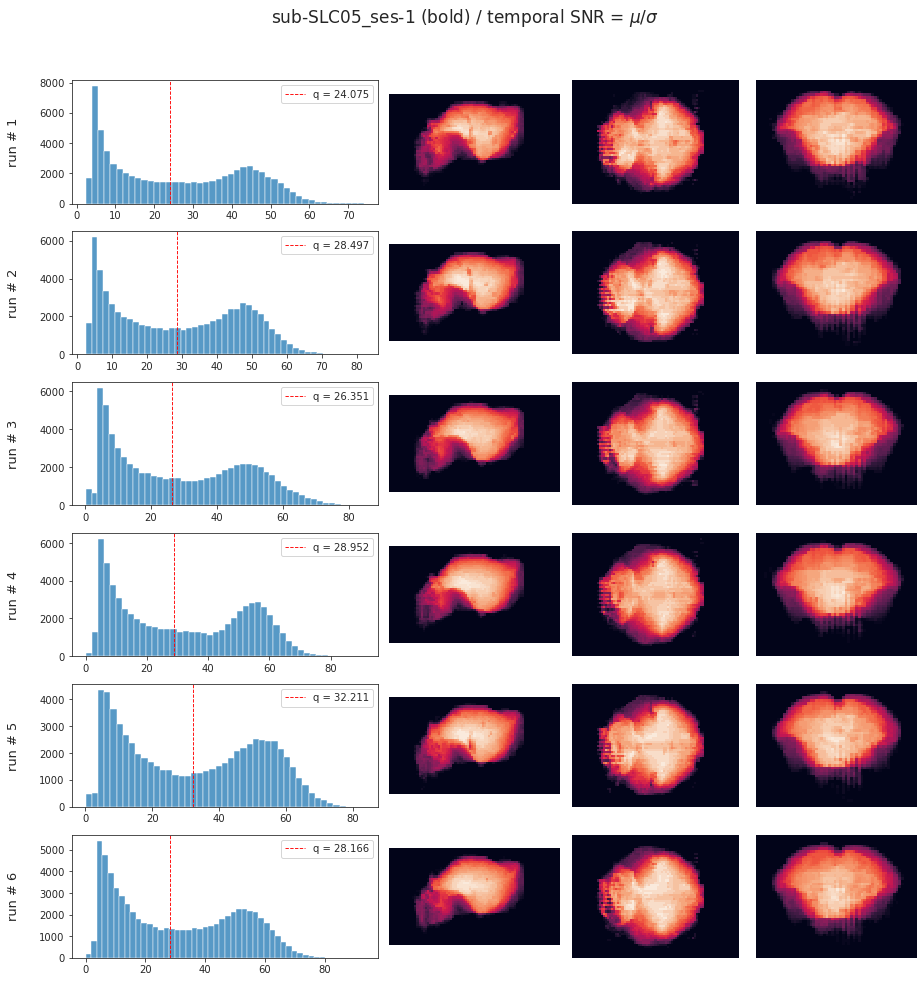

CPU times: user 11.7 s, sys: 7.3 s, total: 19 s
Wall time: 19.1 s


In [50]:
%%time

data, (fig, sup, _) = plot_5(mice, 5, 1)

In [51]:
len(data)

6

In [53]:
snr, m, vals, q = data[1]

In [54]:
snr.shape

(60, 46, 81)

<matplotlib.image.AxesImage object at 0x7ec2a34e1070>

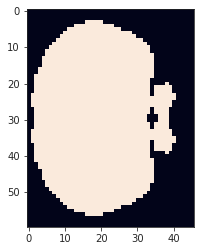

In [57]:
plt.imshow(m[..., 40])

In [58]:
vals

array([8.64024677, 6.89793508, 6.58704249, ..., 7.86608417, 6.74392044,
       5.11139865])

In [59]:
q

24.07524134426312

<matplotlib.image.AxesImage object at 0x7ec2a35048e0>

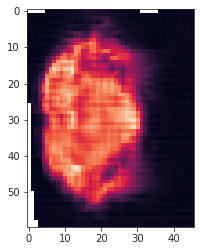

In [55]:
plt.imshow(snr[..., 40])

In [94]:
%%time

threshold = 0.5

figs, sups  = [], []
snr_all, q_vals = [], []

for sub in mice.cfg.sub_ids:
    for ses in mice.cfg.ses_ids:
        try:
            data, (fig, sup, _) = plot_5(
                mice=mice,
                sub=sub,
                ses=ses,
                threshold=threshold,
                display=False,
                raw_bold=True,
                space='N162',
            )
            figs.append(fig)
            sups.append(sup)
            for i in data:
                q_vals.append(data[i][-1])
                snr_all.append(np.expand_dims(data[i][0], 0))
        except (TypeError, KeyError):
            continue
snr_all = np.concatenate(snr_all)
q_vals = np.array(q_vals)

CPU times: user 6min 23s, sys: 18min 17s, total: 24min 40s
Wall time: 37min 51s


In [160]:
save_fig(
    fig=figs,
    sup=sups,
    save_file=pjoin(tmp_dir, f'tsnr_bold_perc{100 * threshold:0.0f}.pdf'),
    display=False,
    multi=True,
)

In [110]:
snr_avg = bn.nanmean(snr_all, 0)
snr_avg.shape

(60, 46, 81)

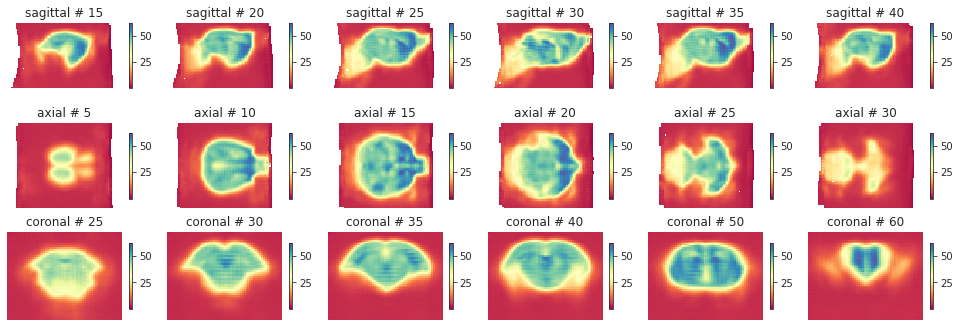

In [137]:
fig, axes = create_figure(3, 6, (13.5, 4.7))

vmin = np.nanmin(snr_avg)
vmax = np.nanmax(snr_avg[np.isfinite(snr_avg)])

for j, s in enumerate([15, 20, 25, 30, 35, 40]):
    ax = axes[0, j]
    ax.set_title(f"sagittal # {s}")
    im = ax.imshow(snr_avg.take(s, 0), cmap='Spectral', vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)

for j, s in enumerate([5, 10, 15, 20, 25, 30]):
    ax = axes[1, j]
    ax.set_title(f"axial # {s}")
    im = ax.imshow(snr_avg.take(s, 1), cmap='Spectral', vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)
    
for j, s in enumerate([25, 30, 35, 40, 50, 60]):
    ax = axes[2, j]
    ax.set_title(f"coronal # {s}")
    im = ax.imshow(snr_avg.take(s, 2).T, cmap='Spectral', vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)
    
remove_ticks(axes)
plt.show()

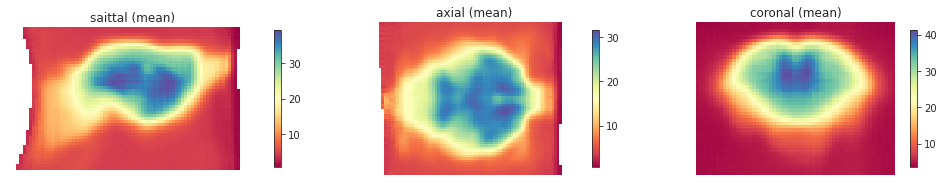

In [153]:
fig, axes = create_figure(1, 3, (13.5, 2.6))

x2plt = snr_avg.copy()
x2plt[~np.isfinite(x2plt)] = np.nan

for i, lbl in enumerate(['saittal', 'axial', 'coronal']):
    axes[i].set_title(f"{lbl} (mean)")
    _x2plt = bn.nanmean(x2plt, i)
    if i == 2:
        _x2plt = _x2plt.T
    im = axes[i].imshow(_x2plt, cmap='Spectral')
    plt.colorbar(im, ax=axes[i], shrink=0.9)
    
remove_ticks(axes)
plt.show()

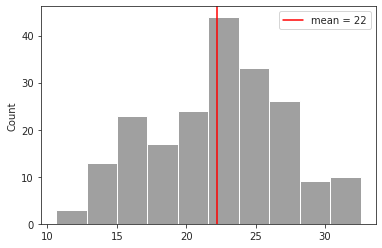

In [154]:
sns.histplot(q_vals, color='grey')
plt.axvline(np.mean(q_vals), color='r', label=f"mean = {np.mean(q_vals):0.0f}")
plt.legend()
plt.show()

In [169]:
(q_vals < 15).sum()

16

In [166]:
np.where(q_vals < 15)[0]

array([  3,  67,  94,  95, 126, 129, 130, 156, 157, 158, 159, 162, 163,
       165, 166, 187])

In [170]:
len(q_vals), len(snr_all)

(202, 202)

In [155]:
in_house = 'Symmetric_N162_0.20.nii.gz'
in_house = pjoin(mice.cfg.base_dir, 'Yale', 'atlases_templates', in_house)
in_house = ants.image_read(in_house)
in_house

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (60, 46, 81)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [156]:
x = snr_avg.copy()
x[~np.isfinite(x)] = np.nan

In [158]:
from register.register import reset_ants_img
snr_img = reset_ants_img(x, spacing=in_house.spacing, origin=in_house.origin, dtype='float', use_um=False)
snr_img

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (60, 46, 81)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [159]:
ants.image_write(snr_img, pjoin(tmp_dir, 'tSNR_avg.nii.gz'))

In [171]:
snr_filt_avg = snr_all.copy()
snr_filt_avg[~np.isfinite(snr_filt_avg)] = np.nan
snr_filt_avg = bn.nanmean(snr_filt_avg[q_vals > 15], 0)

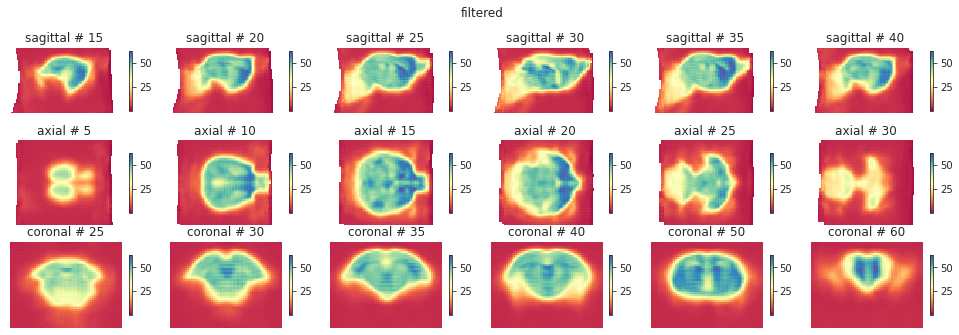

In [172]:
fig, axes = create_figure(3, 6, (13.5, 4.7))

vmin = np.nanmin(snr_filt_avg)
vmax = np.nanmax(snr_filt_avg[np.isfinite(snr_filt_avg)])

for j, s in enumerate([15, 20, 25, 30, 35, 40]):
    ax = axes[0, j]
    ax.set_title(f"sagittal # {s}")
    im = ax.imshow(snr_filt_avg.take(s, 0), cmap='Spectral', vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)

for j, s in enumerate([5, 10, 15, 20, 25, 30]):
    ax = axes[1, j]
    ax.set_title(f"axial # {s}")
    im = ax.imshow(snr_filt_avg.take(s, 1), cmap='Spectral', vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)
    
for j, s in enumerate([25, 30, 35, 40, 50, 60]):
    ax = axes[2, j]
    ax.set_title(f"coronal # {s}")
    im = ax.imshow(snr_filt_avg.take(s, 2).T, cmap='Spectral', vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)
fig.suptitle('filtered')
remove_ticks(axes)
plt.show()

In [173]:
snr_img = reset_ants_img(
    snr_filt_avg,
    spacing=in_house.spacing,
    origin=in_house.origin,
    dtype='float',
    use_um=False,
)
ants.image_write(snr_img, pjoin(tmp_dir, 'tSNR_filt_avg.nii.gz'))

### Some odd examples

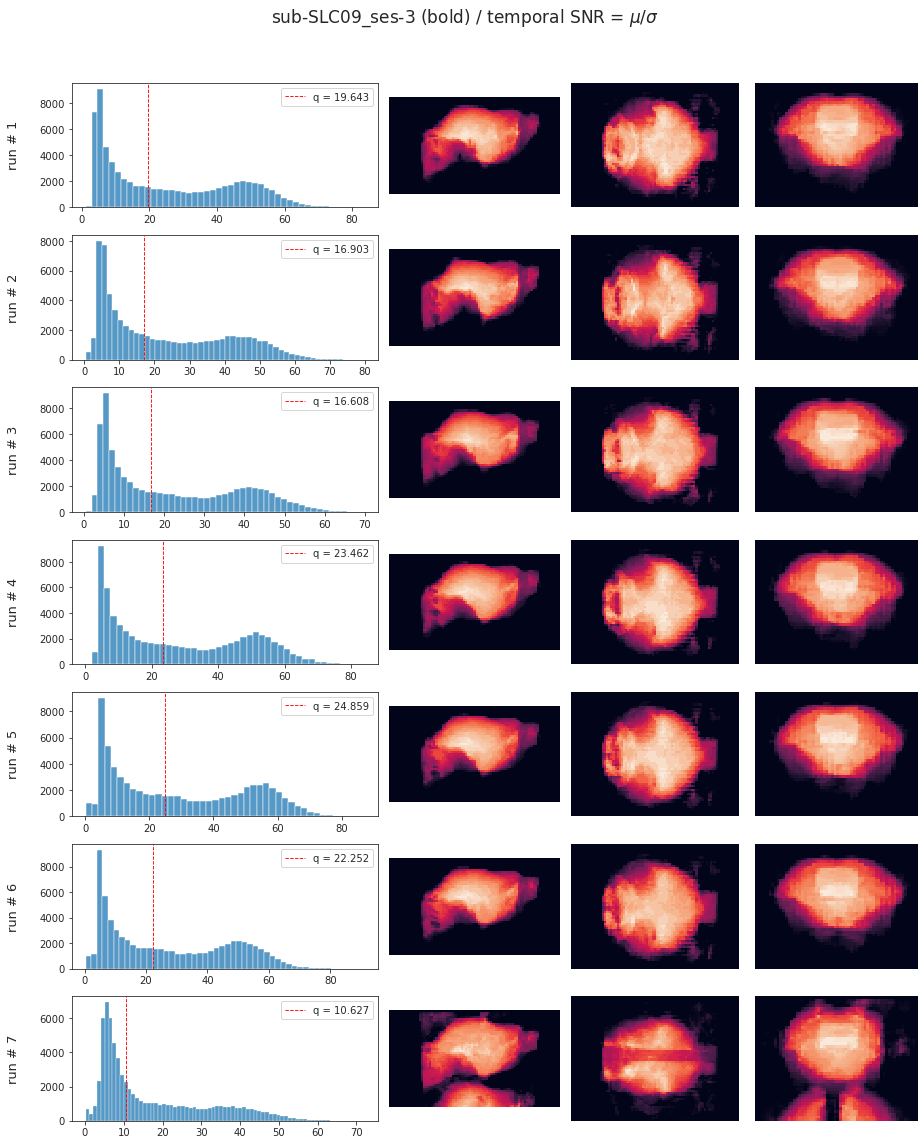

In [162]:
data, (fig, sup, _) = plot_5(mice, 9, 3)

In [175]:
snr, m, vals, q = data[7]
q

10.626739695163021

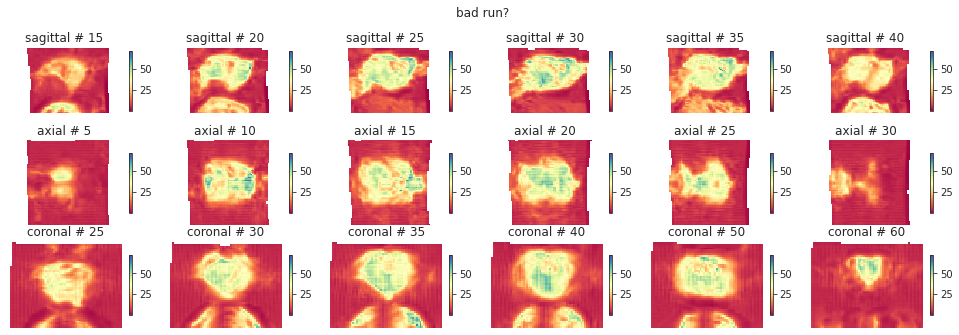

In [183]:
fig, axes = create_figure(3, 6, (13.5, 4.7))

vmin = np.nanmin(snr)
vmax = np.nanmax(snr[np.isfinite(snr)])

for j, s in enumerate([15, 20, 25, 30, 35, 40]):
    ax = axes[0, j]
    ax.set_title(f"sagittal # {s}")
    im = ax.imshow(snr.take(s, 0), cmap='Spectral', vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)

for j, s in enumerate([5, 10, 15, 20, 25, 30]):
    ax = axes[1, j]
    ax.set_title(f"axial # {s}")
    im = ax.imshow(snr.take(s, 1), cmap='Spectral', vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)
    
for j, s in enumerate([25, 30, 35, 40, 50, 60]):
    ax = axes[2, j]
    ax.set_title(f"coronal # {s}")
    im = ax.imshow(snr.take(s, 2).T, cmap='Spectral', vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)
fig.suptitle('bad run?')
remove_ticks(axes)
plt.show()

In [189]:
key = 'sub-SLC09_ses-3_run-7'
_, out3d = _load(mice, key, 'bold', True, 'N162')

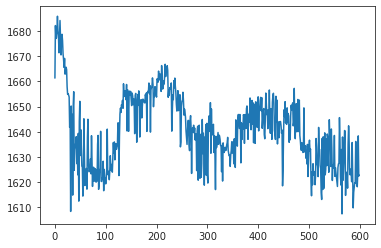

In [190]:
plt.plot(out3d['gs']);

<matplotlib.image.AxesImage object at 0x7ec276e7d370>

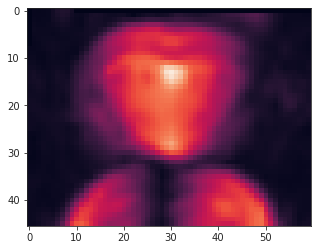

In [192]:
plt.imshow(out3d['x'][..., 40, 120].T)

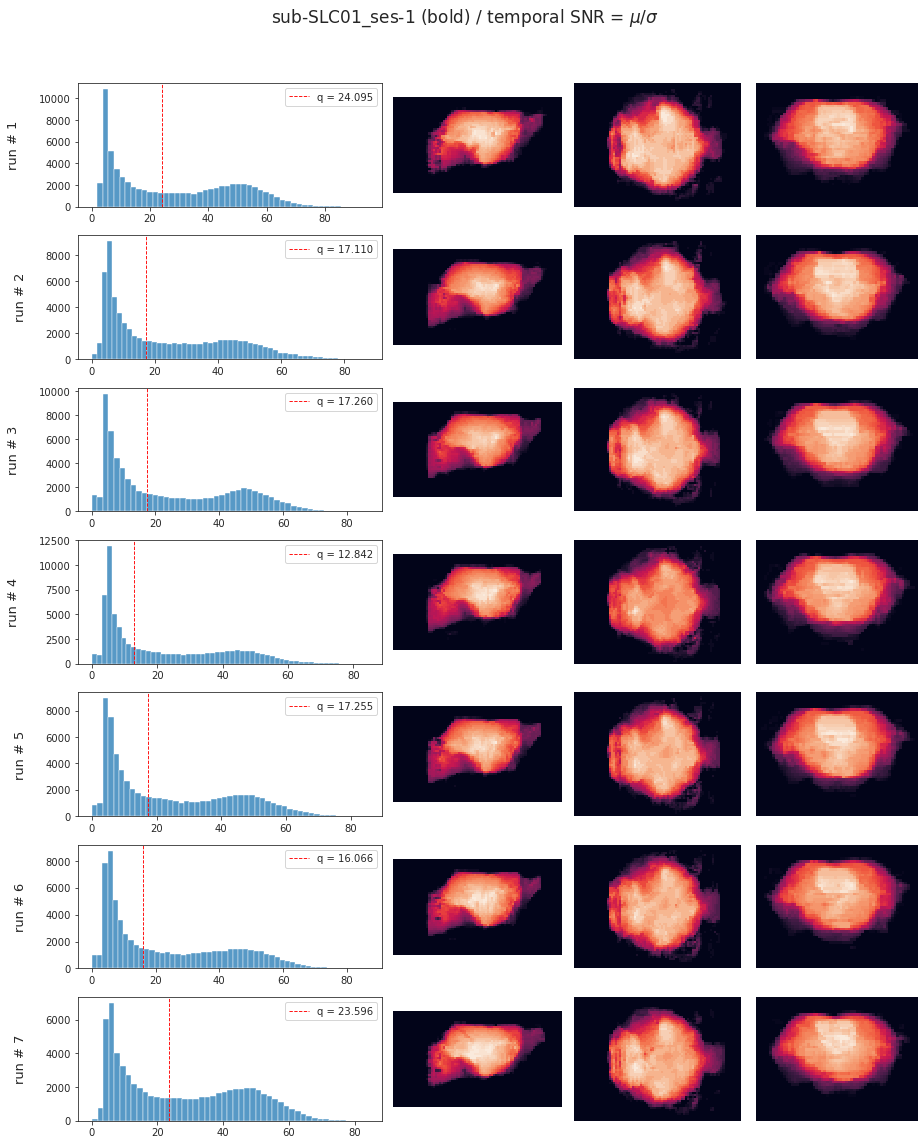

In [161]:
data, (fig, sup, _) = plot_5(mice, 1, 1)

## In common space

In [87]:
key = 'sub-SLC03_ses-3_run-1'

file = next(
    f for f in os.listdir(mice.cfg.npy_dir) if
    all(e in f for e in [key, 'space-N162_desc-raw'])
)
file = pjoin(mice.cfg.npy_dir, file)
x3d = np.load(file)

<matplotlib.image.AxesImage object at 0x7ef2e3f9e310>

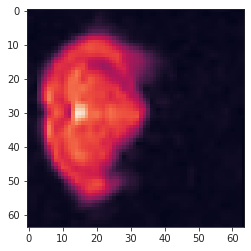

In [88]:
plt.imshow(x3d[..., 40, 120])

In [10]:
key = 'sub-SLC03_ses-3_run-1'

file = next(
    f for f in os.listdir(mice.cfg.npy_dir) if
    all(e in f for e in [key, 'space-N162_desc-raw'])
)
file = pjoin(mice.cfg.npy_dir, file)
x3d = np.load(file)

<matplotlib.colorbar.Colorbar object at 0x7ec2a9ba29d0>

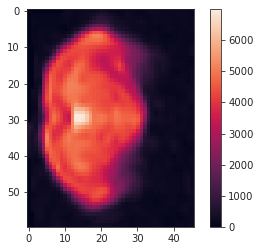

In [11]:
plt.imshow(x3d[..., 40, 120])
plt.colorbar()

In [14]:
mask = np.abs(x3d).mean(-1) > 1000

<matplotlib.image.AxesImage object at 0x7ec2a9883a30>

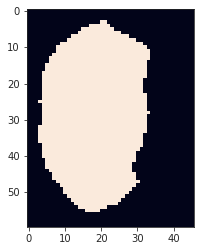

In [15]:
plt.imshow(mask[..., 40])

In [16]:
mu = x3d.mean(-1)
sd = x3d.std(-1)
snr = mu / sd
snr.shape

(60, 46, 81)

<matplotlib.colorbar.Colorbar object at 0x7ec2a973fe20>

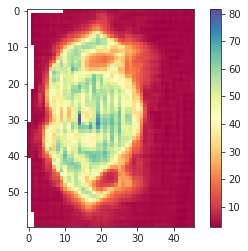

In [17]:
plt.imshow(snr[..., 40], cmap='Spectral')
plt.colorbar()

In [18]:
vals = snr[np.isfinite(snr)]

<AxesSubplot:ylabel='Count'>

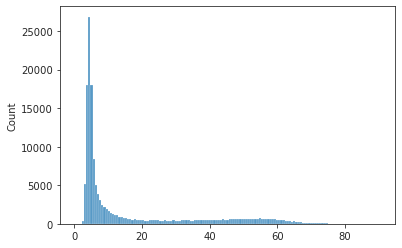

In [19]:
sns.histplot(vals)

In [36]:
file = pjoin(mice.cfg.base_dir, 'Yale', 'atlases_templates', 'Symmetric_N162_0.20.nii.gz')
mask = ants.image_read(file)

In [37]:
mask

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (60, 46, 81)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

<matplotlib.image.AxesImage object at 0x7ec2a8e467c0>

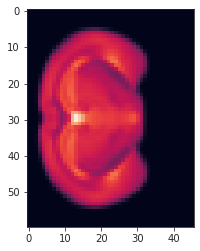

In [38]:
plt.imshow(mask[..., 40])

In [34]:
np.quantile(vals, 0.79)

29.9314145586495

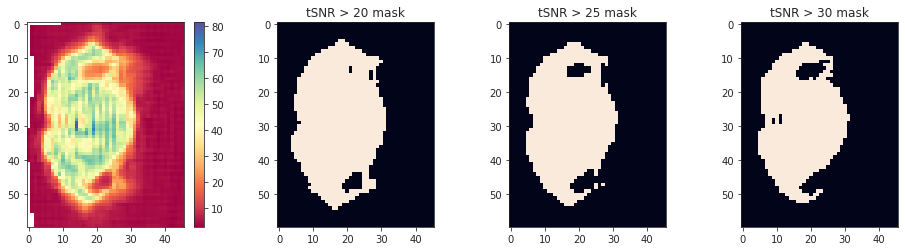

In [165]:
fig, axes = create_figure(1, 4, (13, 3.6))

im = axes[0].imshow(snr[..., 40], cmap='Spectral')
plt.colorbar(im, ax=axes[0])

axes[1].imshow(snr[..., 40] > 20)
axes[1].set_title('tSNR > 20 mask')

axes[2].imshow(snr[..., 40] > 25)
axes[2].set_title('tSNR > 25 mask')

axes[3].imshow(snr[..., 40] > 30)
axes[3].set_title('tSNR > 30 mask')

plt.show()

<matplotlib.colorbar.Colorbar object at 0x7ef2a2510ee0>

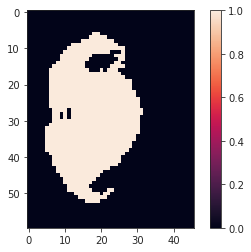

In [148]:
plt.imshow(snr[..., 40] > 30)
plt.colorbar()

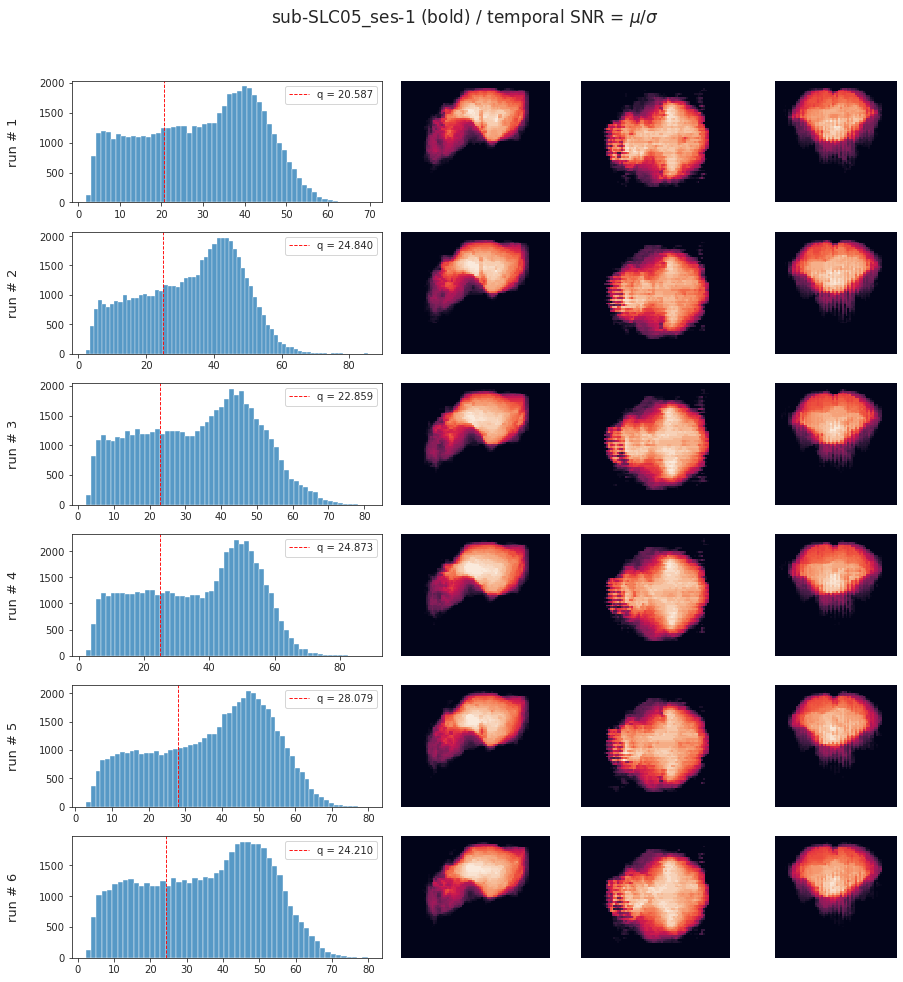

In [157]:
fig, sup, _ = plot_5(mice, 5, 1, True, 0.30)